![./img/sp_tiny.png](./img/sp_tiny.png)
<h1><center>Accent Detection: <br>
Signal Processing  + CNN</center></h1>
<h3><center>Part 4: Signal Processing + CNN </center></h3>
<center>Group 2: Katerina Bosko and Victor Wilm
<center>Northeastern University, CS6140

In [ ]:
import os
from glob import glob
from ipywidgets import IntProgress
import json

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seed value for experiment reproducibility
seed = 36
tf.random.set_seed(seed)
np.random.seed(seed)

In this notebook, we perform CNN on spectograms produced by Signal Processing. The approach is based on the paper by Michailava et al (2022) mentioned in the references. 

# 1. Signal Processing

## Notes on parameters

### Sample rate
Sample rate = 22050 Hz was not changed. This is standard in librosa library.

### STFT window size
https://librosa.org/doc/latest/generated/librosa.stft.html#librosa.stft

n_fft = length of the windowed signal after padding with zeros. The number of rows in the STFT matrix D is (1 + n_fft/2). **The default value, n_fft=2048 samples**, corresponds to a physical duration of 93 milliseconds at a sample rate of 22050 Hz, i.e. the default sample rate in librosa. This value is well adapted for **music signals**. However, in **speech processing, the recommended value is 512**, corresponding to 23 milliseconds at a sample rate of 22050 Hz. In any case, we recommend setting n_fft to a power of two for optimizing the speed of the fast Fourier transform (FFT) algorithm.

Based on above description, n_fft=512 was chosen, which is equivalent to 512/22050=0.023 or 23 ms

### Hop length
Hop length was chosen as window_size // 2 = 512//2 = 256, which is equivalent to 256//22050=0.011 or 11 ms
Such a hop length ensures that there is a signal overlap when extracting STFT features.

### Frame size
Frame size was chosen as 75 frames, which is rather small such that we can extract phonemes. We experimented with a larger number of frame size and it didn't result into higher than 30-40% accuracy scores.


## Notes on processing steps
Preprocessing steps are as follows:

1. Balancing the dataset
2. Signal Processing with the chosen method
3. Normalization at the level of each frequency
4. Segmentation based on the frame size

We experimented with different order of processing steps. For instance, 
1. Segmentation
2. Signal processing
3. Normalization 

or:
1. Normalization
2. Segmentation
3. Signal processing


these approaches also failed (the accuracy scores were not high enough).

In [11]:
def get_max_num_files(dataset_path):
    # get links to audio files
    audio_files = glob(f"{dataset_path}/*/*.wav")
    # note .DS_store needs to be removed
    if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

    languages = os.listdir(dataset_path)
    audio_files_by_lang = {}
    for lang in languages:
        audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")

    num_files_per_lang = [len(audio_files_by_lang[lang]) for lang in audio_files_by_lang]
    return np.array(num_files_per_lang).min()

In [12]:
def limit_num_audio_files_per_lang(dataset_path):
    max_num_files = get_max_num_files(dataset_path)
    if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

    languages = os.listdir(dataset_path)
    lang_mapping = {l: i for i, l in enumerate(languages)}

    audio_files_by_lang = {}
    # limit to MAX_NUM_FILES for each lang
    for lang in languages:
        audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:max_num_files]
        print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")

    audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]
    return audio_files

In [74]:
def extract_features_stft(dataset_path, sample_rate=22050, n_fft=512, frame_size=75):
    hop_length = n_fft // 2

    # get languages mapping for y
    languages = os.listdir(dataset_path)
    lang_mapping = {l: i for i, l in enumerate(languages)}

    # PROCESSING STEPS
    # 1. Balancing the dataset
    audio_files = limit_num_audio_files_per_lang(dataset_path)
    
    # instantiate the progress bar
    f = IntProgress(min=0, max=len(audio_files)) 
    display(f) # display the bar


    X = []
    y = []
    for file in audio_files:
        f.value += 1
        # get file's language
        lang_pos = len(dataset_path.split("/"))
        lang = file.split("/")[lang_pos]
        
        # 2. Signal processing
        signal, sample_rate = librosa.load(file, sr=sample_rate)
        stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
        spectogram = np.abs(stft)
        # log_spectogram.shape = (hop_length, len(signal)/hop_length), e.g. (257, 1852)
        log_spectogram = librosa.amplitude_to_db(spectogram)
        
        # 3. Normalization at the level of each frequency
        log_spectogram_norm_vector = []
        for i in range(log_spectogram.shape[0]):
            log_spectogram_norm = StandardScaler().fit_transform(log_spectogram[i, :].reshape(-1, 1)).reshape(-1)
            log_spectogram_norm_vector.append(log_spectogram_norm)
        features = np.vstack(log_spectogram_norm_vector)
        
        # 4. Segmentation based on frame size
        segments = []
        labels = []
        stft_signal_len = features.shape[1]
        for frame_start in range(0, int(stft_signal_len / frame_size)):
            # features_cut.shape = (hop_length, frame_size), e.g. (257, 75)
            features_cut = features[:, frame_start * frame_size:(frame_start + 1) * frame_size]
            # num segments = stft_signal_len // frame_size, e.g. 1852 // 75 = 24
            segments.append(features_cut)
            labels.append(lang_mapping[lang])
        # X_per_file.shape = (hop_length * num_segments, frame_size), e.g. (257 * 24, 75)=(6168, 75) 
        X_per_file = np.vstack(segments)
        y_per_file = np.vstack(labels)
        # X.shape = (sum(hop_length * num_segments per file), frame_size), e.g. ((6168+7453+6939...), 75)
        X.append(X_per_file)
        # y is same as total number of segments
        y.append(y_per_file)
    
    # transform X list into np.array (doesn't change shape)
    X = np.vstack(X)
    y = np.vstack(y)
    
    # reshape into (total_num_segments, hop_length, frame_size)
    total_num_segments = y.shape[0]
    X_temp = X.reshape(total_num_segments, -1, frame_size)
    return X, y 

# Languages set 1: English, Russian, German, Mandarin

In [73]:
dataset_path = "./data/lang_set_1"
X, y = extract_features_stft(dataset_path)

num audio files for GERMAN: 45
num audio files for MANDARIN: 45
num audio files for RUSSIAN: 45
num audio files for ENGLISH: 45


IntProgress(value=0, max=180)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


## Preprocessing decisions:
(UPDATE)

1. Do not trim leading and trailing silence from an audio signal (below 20 db is considered as silence)
2. Cut signal to a specified duration (FRAME_SIZE = 85)
3. STFT/MFCC window size = 512 

In [23]:
# def extract_features_mfcc_by_frame_size(dataset_path, MAX_NUM_FILES=45, FRAME_SIZE=75, sample_rate=22050, n_fft=512, num_mfcc=13):
#     hop_length = n_fft // 2
    
#     if '.DS_Store' in os.listdir(dataset_path):
#         os.remove(f'{dataset_path}/.DS_Store')

#     languages = os.listdir(dataset_path)
#     lang_mapping = {l: i for i, l in enumerate(languages)}


#     audio_files_by_lang = {}
#     # limit to MAX_NUM_FILES for each lang
#     for lang in languages:
#         audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:MAX_NUM_FILES]
#         print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")
# # 
#     audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]
    
#     # instantiate the progress bar
#     f = IntProgress(min=0, max=len(audio_files)) 
#     display(f) # display the bar


#     X = []
#     y = []
#     for file in audio_files:
#         f.value += 1
#         lang_pos = len(dataset_path.split("/"))
#         lang = file.split("/")[lang_pos]
        
#         signal, sample_rate = librosa.load(file, mono=True)
        
#         mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
#         mfcc_norm_vector = []
#         for i in range(mfcc.shape[0]):
#             mfcc_norm = StandardScaler().fit_transform(mfcc[i, :].reshape(-1, 1)).reshape(-1)
#             mfcc_norm_vector.append(mfcc_norm)

#         features = np.vstack(mfcc_norm_vector)
#         # features shape (num_mfcc, math.ceil(signal_len/n_fft))
#         # print("mfcc_norm -> features.shape", features.shape)

#         segments = []
#         labels = []
#         for frame_start in range(0, int(features.shape[1] / FRAME_SIZE)):
#             features_cut = features[:, frame_start * FRAME_SIZE:(frame_start + 1) * FRAME_SIZE]
#             # features_cut shape (num_mfcc, frame_size)
#             # print("features_cut.shape", features_cut.shape)
#             segments.append(features_cut)
#             # print("segments len per file")
#             labels.append(lang_mapping[lang])
#         X_per_lang = np.vstack(segments)
#         y_per_lang = np.vstack(labels)
#         X.append(X_per_lang)
#         y.append(y_per_lang)
 
#     X = np.vstack(X)
#     y = np.vstack(y)

#     X = X.reshape(y.shape[0], -1, X.shape[1])
#     print(X.shape, y.shape)
#     return X, y 

In [5]:
# def extract_melspectogram_by_frame_size(dataset_path, win_len, hop_len, MAX_NUM_FILES=45, FRAME_SIZE=75, sample_rate=22050):
    
#     if '.DS_Store' in os.listdir(dataset_path):
#         os.remove(f'{dataset_path}/.DS_Store')

#     languages = os.listdir(dataset_path)
#     lang_mapping = {l: i for i, l in enumerate(languages)}


#     audio_files_by_lang = {}
#     # limit to MAX_NUM_FILES for each lang
#     for lang in languages:
#         audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:MAX_NUM_FILES]
#         print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")

#     audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]
    
#     # instantiate the progress bar
#     f = IntProgress(min=0, max=len(audio_files)) 
#     display(f) # display the bar


#     X = []
#     y = []
#     for file in audio_files:
#         f.value += 1
#         lang_pos = len(dataset_path.split("/"))
#         lang = file.split("/")[lang_pos]
        
#         signal, _ = librosa.load(file, sr=sample_rate)
#         # mel_sp shape (n_mels, len(signal)/hop_length)
#         mel_sp = librosa.feature.melspectrogram(y=signal, sr=sample_rate, n_mels=N_MELS, hop_length=hop_len,
#                                            win_length=win_len, power=1.0)
        
#         # standardize along N_MELS axis
#         mel_sp_norm_vector = []
#         for i in range(mel_sp.shape[0]):
#             mel_sp_norm = StandardScaler().fit_transform(mel_sp[i, :].reshape(-1, 1)).reshape(-1)
#             mel_sp_norm_vector.append(mel_sp_norm)

#         features = np.vstack(mel_sp_norm_vector)
  
#         segments = []
#         labels = []
#         for frame_start in range(0, int(features.shape[1] / FRAME_SIZE)):
#             features_cut = features[:, frame_start * FRAME_SIZE:(frame_start + 1) * FRAME_SIZE]
#             # features_cut shape (num_mfcc, frame_size)
#             # print("features_cut.shape", features_cut.shape)
#             segments.append(features_cut)
#             # print("segments len per file")
#             labels.append(lang_mapping[lang])
#         X_per_lang = np.vstack(segments)
#         y_per_lang = np.vstack(labels)
#         X.append(X_per_lang)
#         y.append(y_per_lang)
 
#     X = np.vstack(X)
#     y = np.vstack(y)

#     X = X.reshape(y.shape[0], -1, X.shape[1])
#     print(X.shape, y.shape)
#     return X, y 

In [69]:
def extract_features_cwt_by_frame_size(dataset_path, MAX_NUM_FILES=45, FRAME_SIZE=75, sample_rate=22050):
    hop_length = n_fft // 2
    
    if '.DS_Store' in os.listdir(dataset_path):
        os.remove(f'{dataset_path}/.DS_Store')

    languages = os.listdir(dataset_path)
    lang_mapping = {l: i for i, l in enumerate(languages)}


    audio_files_by_lang = {}
    # limit to MAX_NUM_FILES for each lang
    for lang in languages:
        audio_files_by_lang[lang] = glob(f"{dataset_path}/{lang}/*.wav")[:MAX_NUM_FILES]
        print(f"num audio files for {lang.upper()}: {len(audio_files_by_lang[lang])}")
# 
    audio_files = [file for lang_files in audio_files_by_lang.values() for file in lang_files]
    
    # instantiate the progress bar
    f = IntProgress(min=0, max=len(audio_files)) 
    display(f) # display the bar

    scales = range(64)
    waveletname = 'morl' 

    X = []
    y = []
    for file in audio_files:
        f.value += 1
        lang_pos = len(dataset_path.split("/"))
        lang = file.split("/")[lang_pos]
        
        signal, sample_rate = librosa.load(file, mono=True)
        
        cwt_coeff, freq = pywt.cwt(signal, scales, waveletname, 1)
        cwt_norm_vector = []
        for i in range(cwt_coeff.shape[0]):
            cwt_norm = StandardScaler().fit_transform(cwt_coeff[i, :].reshape(-1, 1)).reshape(-1)
            cwt_norm_vector.append(cwt_norm)

        features = np.vstack(mfcc_norm_vector)
        # features shape (num_mfcc, math.ceil(signal_len/n_fft))
        # print("mfcc_norm -> features.shape", features.shape)

        segments = []
        labels = []
        for frame_start in range(0, int(features.shape[1] / FRAME_SIZE)):
            features_cut = features[:, frame_start * FRAME_SIZE:(frame_start + 1) * FRAME_SIZE]
            # features_cut shape (num_mfcc, frame_size)
            # print("features_cut.shape", features_cut.shape)
            segments.append(features_cut)
            # print("segments len per file")
            labels.append(lang_mapping[lang])
        X_per_lang = np.vstack(segments)
        y_per_lang = np.vstack(labels)
        X.append(X_per_lang)
        y.append(y_per_lang)
 
    X = np.vstack(X)
    y = np.vstack(y)

    X = X.reshape(y.shape[0], -1, X.shape[1])
    print(X.shape, y.shape)
    return X, y 

# 2. Feature extraction

In [53]:
SAMPLE_RATE = 22050
N_MELS = 64
OVERLAP_MS = 10
WIN_LENGTH_MS = 25
HOP_LENGTH = int(SAMPLE_RATE * 0.001 * OVERLAP_MS)  # [10 ms overlap]
WIN_LENGTH = int(SAMPLE_RATE * 0.001 * WIN_LENGTH_MS)  # [25 ms window length]
# N_FFT = int(SAMPLE_RATE * 0.001 * WIN_LENGTH)  # [25 ms window length]
FRAME_SIZE = 75  # 30 / 50 / 70 / 100 / 150 / 200 / 300 / 500 [Size of feature segment]

WIN_LENGTH,HOP_LENGTH

(551, 220)

In [70]:
DATASET_PATH = "./data/original"
MAX_NUM_FILES = 45 if dataset_path == "./data/original" else 80
# X, y = extract_features_mfcc_by_frame_size(DATASET_PATH, MAX_NUM_FILES=MAX_NUM_FILES)
# X, y = extract_melspectogram_by_frame_size(DATASET_PATH, WIN_LENGTH, HOP_LENGTH, MAX_NUM_FILES=MAX_NUM_FILES, FRAME_SIZE=FRAME_SIZE)
# X, y = extract_features_stft_by_frame_size(DATASET_PATH, MAX_NUM_FILES=MAX_NUM_FILES)
X, y = extract_features_stft_by_frame_size(DATASET_PATH, MAX_NUM_FILES=MAX_NUM_FILES)

num audio files for GERMAN: 45
num audio files for MANDARIN: 45
num audio files for RUSSIAN: 45
num audio files for ENGLISH: 45


IntProgress(value=0, max=180)

(10991, 257, 75) (10991, 1)


In [55]:
X.shape, y.shape

((10991, 257, 75), (10991, 1))

In [9]:
# data = {"x": X.tolist(), "y": y.tolist(), "x_shape": X.shape, "y_shape": y.shape}
# JSON_PATH = "./data/stft_normalized_segmentedafter_oldlang.json"

# with open(JSON_PATH, "w") as fp:
#     json.dump(data, fp, indent=4)

## Splitting into Train, Validation, Test

In [10]:
def prepare_datasets(X, y, test_size, validation_size):
    """
    Loads data and splits it into train, validation and test sets
    """

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size, random_state=1234)

    # add an axis to input sets (aka channel for image)
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test

In [71]:
X_train, X_val, X_test, y_train, y_val, y_test = prepare_datasets(X, y, 0.25, 0.2)

In [72]:
# shape (`batch_size`, `height`, `width`, `channels`)
X_train.shape, X_val.shape, X_test.shape

((6594, 257, 75, 1), (1649, 257, 75, 1), (2748, 257, 75, 1))

# CNN

In [73]:
def plot_history(history):
    """
    Plots accuracy/loss for training/validation set as a function of the epochs
    """

    fig, ax = plt.subplots(figsize=(12,6), ncols=2)

    # accuracy sublpot
    ax[0].plot(history.history["accuracy"], label="train accuracy")
    ax[0].plot(history.history["val_accuracy"], label="val accuracy")
    ax[0].set_ylabel("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[0].set_ylim([0,1])
    ax[0].set_title("Accuracy")

    # loss sublpot
    ax[1].plot(history.history["loss"], label="train error")
    ax[1].plot(history.history["val_loss"], label="val error")
    ax[1].set_ylabel("Error")
    ax[1].set_xlabel("Epoch")
    ax[1].set_title("Loss")
    plt.legend()

    plt.show()

In [74]:
def plot_confusion_matrix(model, X_test, languages):
    """
    Plots confusion matrix for model prediction on test 
    """

    y_pred = model.predict(X_test)

    y_pred = np.argmax(y_pred, axis=1)

    y_true = y_test

    confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_mtx,
                xticklabels=languages,
                yticklabels=languages,
                annot=True, fmt='g')
    plt.xlabel('Prediction')
    plt.ylabel('Label')
    plt.show()

In [75]:
input_shape = X_train.shape[1:]
input_shape

(257, 75, 1)

In [76]:
NUM_LABELS = 4

tf.keras.backend.clear_session()
model = Sequential()

# 1st conv layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
# model.add(MaxPooling2D())

# 2nd conv layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
# model.add(MaxPooling2D())
model.add(Dropout(0.1))

# flatten output and feed it into dense layer
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))

# output layer
model.add(Dense(NUM_LABELS, activation='softmax'))

In [77]:
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam
# default values: lr=0.001 beta_1=0.9 beta_2=0.999 as in paper
optimiser = Adam()
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 255, 73, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 255, 73, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 37, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 126, 35, 64)       18496     
                                                                 
 batch_normalization_1 (Batc  (None, 126, 35, 64)      256       
 hNormalization)                                                 
                                                        

From paper: 

"The training stopped when the change in accuracy was at least 0.5% for an interval of 20 epochs or when 300 epochs were reached among five accents, and 170 epochs in other cases."

In [78]:
# consider an improvement 1% for accuracy specified by min_delta
# es = EarlyStopping(monitor='val_accuracy', mode='auto', min_delta=1, patience=20, restore_best_weights=True, verbose=1)

NUM_EPOCHS = 60
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS, callbacks=[es])
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS)


Epoch 1/60
104/104 [==============================] - 111s 1s/step - loss: 5.2405 - accuracy: 0.2830 - val_loss: 62.5805 - val_accuracy: 0.2717
Epoch 2/60
104/104 [==============================] - 109s 1s/step - loss: 1.3945 - accuracy: 0.2909 - val_loss: 56.2815 - val_accuracy: 0.2784
Epoch 3/60
104/104 [==============================] - 108s 1s/step - loss: 1.3821 - accuracy: 0.2934 - val_loss: 20.3782 - val_accuracy: 0.2729
Epoch 4/60
104/104 [==============================] - 99s 955ms/step - loss: 1.3788 - accuracy: 0.2956 - val_loss: 3.5787 - val_accuracy: 0.2498
Epoch 5/60
104/104 [==============================] - 104s 998ms/step - loss: 1.3747 - accuracy: 0.2924 - val_loss: 1.4709 - val_accuracy: 0.2862
Epoch 6/60
104/104 [==============================] - 104s 996ms/step - loss: 1.3676 - accuracy: 0.2991 - val_loss: 1.3809 - val_accuracy: 0.2893
Epoch 7/60
104/104 [==============================] - 103s 992ms/step - loss: 1.3730 - accuracy: 0.3009 - val_loss: 1.4187 - val_ac

In [65]:
# NUM_EPOCHS = 60
# # history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS, callbacks=[es])
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS)

Epoch 1/60
104/104 [==============================] - 142s 1s/step - loss: 0.7622 - accuracy: 0.6316 - val_loss: 1.0870 - val_accuracy: 0.5525
Epoch 2/60
104/104 [==============================] - 132s 1s/step - loss: 0.7356 - accuracy: 0.6391 - val_loss: 1.1569 - val_accuracy: 0.5555
Epoch 3/60
104/104 [==============================] - 123s 1s/step - loss: 0.7288 - accuracy: 0.6463 - val_loss: 1.1538 - val_accuracy: 0.5197
Epoch 4/60
104/104 [==============================] - 120s 1s/step - loss: 0.7132 - accuracy: 0.6682 - val_loss: 1.0456 - val_accuracy: 0.5500
Epoch 5/60
104/104 [==============================] - 119s 1s/step - loss: 0.6896 - accuracy: 0.6780 - val_loss: 1.1640 - val_accuracy: 0.5379
Epoch 6/60
104/104 [==============================] - 118s 1s/step - loss: 0.6878 - accuracy: 0.6783 - val_loss: 1.1013 - val_accuracy: 0.5300
Epoch 7/60
104/104 [==============================] - 117s 1s/step - loss: 0.6883 - accuracy: 0.6791 - val_loss: 1.3136 - val_accuracy: 0.5324

Epoch 58/60
104/104 [==============================] - 139s 1s/step - loss: 0.4005 - accuracy: 0.8289 - val_loss: 1.1777 - val_accuracy: 0.6301
Epoch 59/60
104/104 [==============================] - 127s 1s/step - loss: 0.4040 - accuracy: 0.8250 - val_loss: 1.2510 - val_accuracy: 0.6264
Epoch 60/60
104/104 [==============================] - 139s 1s/step - loss: 0.3960 - accuracy: 0.8273 - val_loss: 1.2141 - val_accuracy: 0.6331


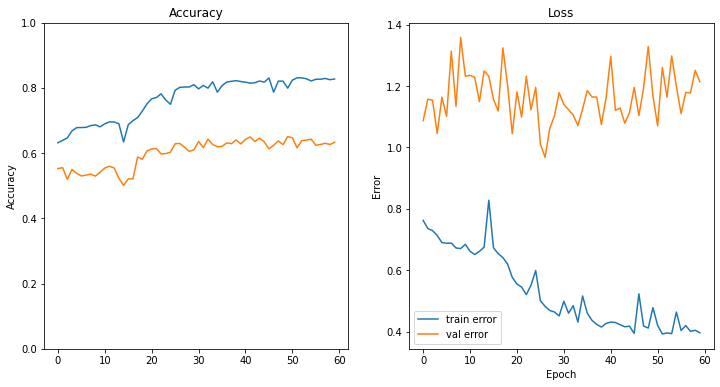

In [66]:
plot_history(history)

In [20]:
# NUM_EPOCHS = 9
# # history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS, callbacks=[es])
# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=64, epochs=NUM_EPOCHS)


## Evaluation

In [67]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

86/86 - 13s - loss: 1.1341 - accuracy: 0.6528 - 13s/epoch - 154ms/step


86/86 [==============================] - 12s 144ms/step


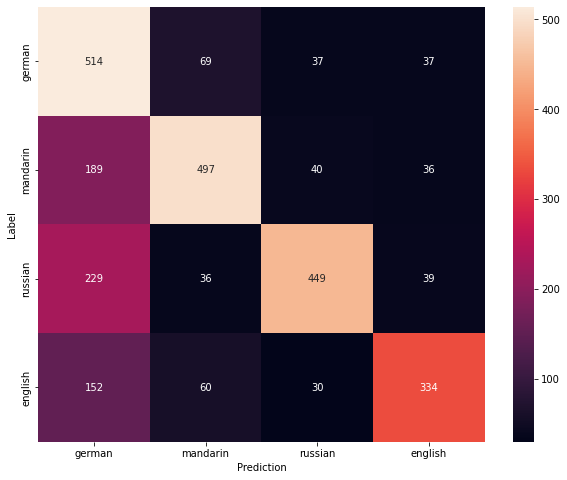

In [68]:
plot_confusion_matrix(model, X_test, languages)

# References:

Mikhailava, V.; Leshnichaia, M.; Bogach, N.; Lezhenin, I.; Blake, J.; Pyshkin, E. Language Accent Detection with CNN Using Sparse Data from a Crowd-Sourced Speech Archive. Mathematics 2022, 10, 2913. https://doi.org/10.3390/ math10162913 